### The purpose of this notebook will be to import each relevant dataset and decide which columns are relevant as well as some feature engineering for each dataset

In [1]:
import pandas as pd
import numpy as np

In [2]:
# First I'll import the datasets. I will not be using the bureau_balance.csv and POS_CASH_balance.csv

# Import the main training data
train_df = pd.read_csv('Raw_Data/application_train.csv', encoding='utf-8')

# Import the bureau data
bureau_df = pd.read_csv('Raw_Data/bureau.csv', encoding='utf-8')

# Import the credit_card data
credit_card_df = pd.read_csv('Raw_Data/credit_card_balance.csv', encoding='utf-8')

# Import the previous applications data
previous_app_df = pd.read_csv('Raw_Data/previous_application.csv', encoding='utf-8')

# Import the installments data
installments_df = pd.read_csv('Raw_Data/installments_payments.csv', encoding='utf-8')

In [3]:
# Let's take a quick look at the shape of each
df_list = [train_df, bureau_df, credit_card_df, installments_df, previous_app_df]

for df in df_list:
    print (df.shape)

(307511, 122)
(1716428, 17)
(3840312, 23)
(13605401, 8)
(1670214, 37)


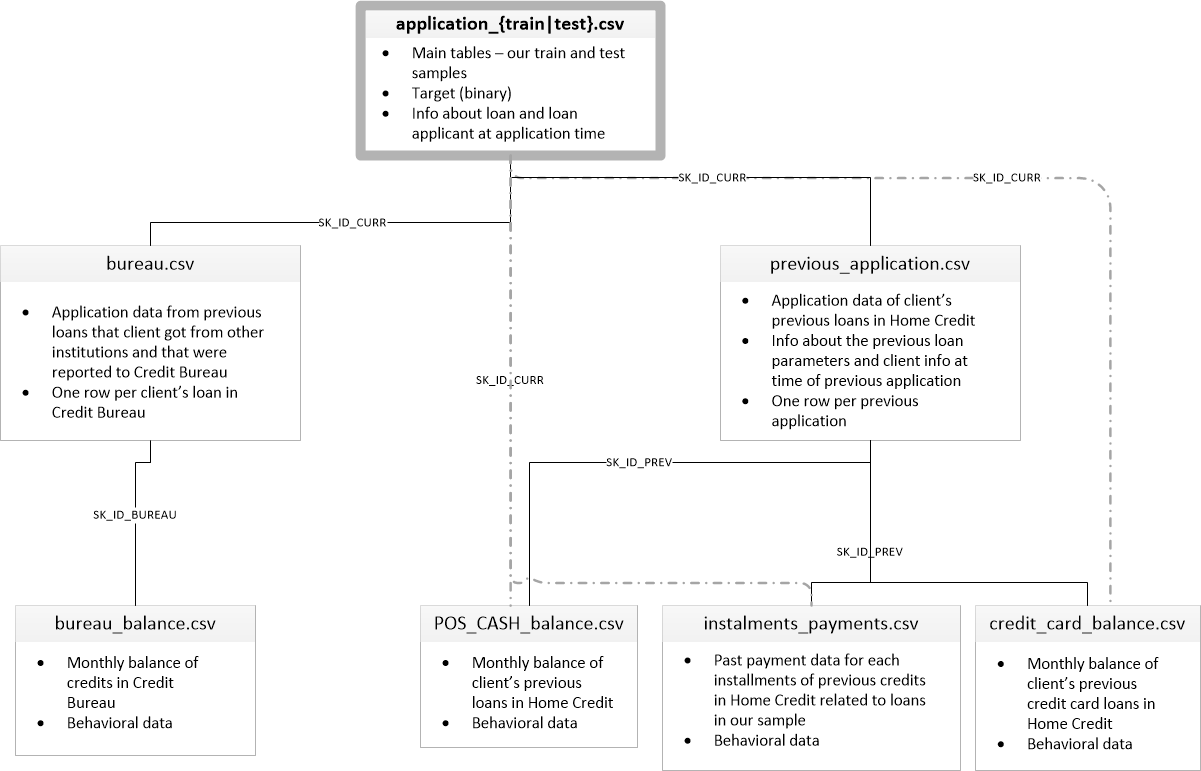

### Main Training Data

I'll start my exploration with the main training data. I have gone through the provided csv file with the description of all the columns. I've selected the most relevant columns (to my knowledge). Additionally, I've selected columns that I will use in feature engineering

In [4]:
# Import StandardScaler from sklearn.preprocessing
from sklearn.preprocessing import StandardScaler, Imputer

# Import RandomForestClassifier from sklearn.ensemble
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Define all the NUMERICAL columns as dtype float64
NUMERICAL = [col for col in train_df.columns if train_df[col].dtype == 'float64']

TO_ADD = ['CNT_CHILDREN', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'REGION_RATING_CLIENT',
         'REGION_RATING_CLIENT_W_CITY']

NUMERICAL.extend(TO_ADD)

# I'll take everything else as CATEGORICAL columns
CATEGORICAL = [col for col in train_df.columns if col not in NUMERICAL]

In [6]:
# Fit the numerical data to a Imputer()
NUMERICAL_df = Imputer().fit_transform(train_df[NUMERICAL],'median')

# Fit the numerical data to the StandardScaler()
NUMERICAL_X_train = StandardScaler().fit_transform(NUMERICAL_df)

# Fit the converted data to the LogisticRegression()
rf = RandomForestClassifier().fit(NUMERICAL_X_train, train_df['TARGET'])

In [7]:
importances = rf.feature_importances_.tolist()
NUMERICAL_df = pd.DataFrame({'features': NUMERICAL, 'importance': importances})
NUMERICAL_df.sort_values(by='importance', ascending=False, inplace=True)

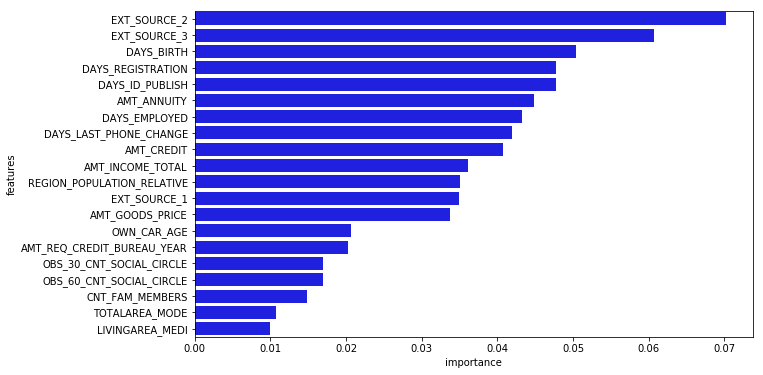

In [8]:
# Display a horizontal barplot with the top 20 feature importances
plt.figure(figsize=(10,6))
sns.barplot(x=NUMERICAL_df['importance'][:20], y=NUMERICAL_df['features'][:20], color='blue', orient='h')

In [9]:
# Let's take a quick look at all the variables with correlation to the target
target_corr = train_df.corr()['TARGET']. sort_values()

print ('Highest 5 Positive Correlation:\n', target_corr.tail())
print ('\nHighest 5 Negative Correlation:\n', target_corr.head())

Highest 5 Positive Correlation:
 DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Highest 5 Negative Correlation:
 EXT_SOURCE_3    -0.178919
EXT_SOURCE_2    -0.160472
EXT_SOURCE_1    -0.155317
DAYS_EMPLOYED   -0.044932
FLOORSMAX_AVG   -0.044003
Name: TARGET, dtype: float64


There isn't any particularly strong positive correlation, but the EXT_SOURCE [3,2,1] (represents "Normalized score fro mexternal data source") stand out in the negative correlation. I'll take note of this so I can add them to my analysis and potentially combine them using feature engineering. 

In [10]:
# Define the columns of interest
TRAIN_COI = ['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
             'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE',
             'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
             'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
             'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_CONT_MOBILE', 
             'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 
             'REG_REGION_NOT_LIVE_REGION', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE']

# Define the columns of exterior sources
EXT_SOURCE = ['EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1']

# Define the columns of documents
DOCUMENTS = ['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 
             'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
             'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13',
             'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
             'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']

# Define the columns of enquiries
ENQUIRIES = ['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
             'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']

# Add the list of documents and enquiries to the columns of interest
TRAIN_COI = TRAIN_COI + DOCUMENTS + ENQUIRIES + EXT_SOURCE

In [11]:
# Reindex the training data with only the columns of interest
train_df = train_df.reindex(TRAIN_COI, axis=1).copy()

In [12]:
train_df.shape

(307511, 57)

At this point, I was able to select 55 columns from 122 potential columns (>50% reduction in variables). Next is some minor feature engineering.

These will be simply summing up some of the variables that appear to be supplementary.

In [13]:
# Define a valid mobile column. This will account if a mobile phone was provided and if it was
# reachable
train_df['VALID_MOBILE'] = (train_df['FLAG_MOBIL'] + train_df['FLAG_CONT_MOBILE']) == 2

# Define a new column for quality of the region and quality of housing relative to region
# I'll put a higher weight on the quality of the region, and a lower weight on the relative rating (3.33 - 10)
train_df['HOUSING'] = (train_df['REGION_RATING_CLIENT'] * 3) + (train_df['REGION_RATING_CLIENT_W_CITY'] / 3)

# Define the new documents column. Take the sum to count how many documents were provided.
train_df['DOCUMENTS'] = train_df[DOCUMENTS].sum(1)

# Define the new enquiries column. Take the sum to count total enquiries to the Credit Bureau over
# the past year.
train_df['ENQUIRIES'] = train_df[ENQUIRIES].sum(1)

In [14]:
# Check the correlation between each of the EXT_SOURCE
train_df[EXT_SOURCE].corr()

EXT_SOURCE_3  EXT_SOURCE_2  EXT_SOURCE_1
EXT_SOURCE_3      1.000000      0.109167      0.186846
EXT_SOURCE_2      0.109167      1.000000      0.213982
EXT_SOURCE_1      0.186846      0.213982      1.000000

It looks like there isn't strong correlation between each of the EXT_SOURCE. As a result, I can assume that the the values are supplementary of each other, not redundant. I will not be performing any feature engineering on them.

Now that I have created 4 new columns, I will remove all the columns I used to engineer those new columns

In [15]:
# Create a list of columns to drop.
TRAIN_DROP = ['FLAG_MOBIL', 'FLAG_CONT_MOBILE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY']

# Append the list of documents and enquiries to the list to drop.
TRAIN_DROP += DOCUMENTS + ENQUIRIES

# Drop the columns
new_train = train_df.drop(TRAIN_DROP, axis=1)

# Sanity Check to make sure all the columns were dropped properly
assert len(new_train.columns) == (len(train_df.columns) - len(TRAIN_DROP))

# Sanity check to ensure no rows were lost during this process
assert len(new_train) == len(train_df)

In [16]:
# Write the csv to an intermediate csv for use in data wrangling notebook
new_train.to_csv('.\Intermediate_Data\\intermediate_train.csv', encoding='utf-8')

### Bureau Dataset

With the bureau dataset, my goal is reduce the dataset so that each client is represented by a single row. This means I will be separating the dataframe into two: active and closed credits. I will merge them back together after some feature engineering on them.

In [17]:
bureau_df.head()

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

In [18]:
# I'll start by defining a list with the columns of interest
BUREAU_COI = ['SK_ID_CURR', 'CREDIT_ACTIVE', 'DAYS_CREDIT', 'AMT_CREDIT_SUM']

# Reindex the data with the columns of interest
bureau_df = bureau_df.reindex(BUREAU_COI, axis=1).copy()

# Separate the daataframe into active and closed
active_bureau = bureau_df[bureau_df['CREDIT_ACTIVE'] == 'Active'].copy() 
closed_bureau = bureau_df[bureau_df['CREDIT_ACTIVE'] == 'Closed'].copy()

In [19]:
# For the active data, I want to the total of all ongoing accounts as well as taking a count of how many ongoing credits
# there are at the time. For days_credit, I'll take the maximum to see when was the last time the client applied for credit

# First I'll start by defining an active count
active_bureau['ONGOING_CREDIT'] = 1

# I'll create the remainder of the columns during groupby
new_active_bureau = active_bureau.groupby('SK_ID_CURR').agg({'DAYS_CREDIT': 'max',
                                                            'AMT_CREDIT_SUM': 'sum',
                                                            'ONGOING_CREDIT': 'sum'}).reset_index()

# Redefine the columns
new_active_bureau.columns = ['SK_ID_CURR', 'LAST_ONGOING_APP', 'TOTAL_ONGOING', 'ONGOING_CREDIT']

In [20]:
# For the closed data, I want to the total of all closed accounts as well as taking a count of how many ongoing credits
# there are at the time.

# First I'll start by defining an active count
closed_bureau['CLOSED_CREDIT'] = 1

# I'll create the remainder of the columns during groupby
new_closed_bureau = closed_bureau.groupby('SK_ID_CURR').agg({'AMT_CREDIT_SUM': 'sum',
                                                            'CLOSED_CREDIT': 'sum'}).reset_index()

# Redefine the columns
new_closed_bureau.columns = ['SK_ID_CURR', 'TOTAL_CLOSED', 'CLOSED_CREDIT']

In [21]:
# Merge the two columns together using outer merge.
# new_bureau_df = new_active_bureau.merge(new_closed_bureau, how='outer', on='SK_ID_CURR')

# Sanity check to make sure no ids were lost during this process
# assert bureau_df['SK_ID_CURR'].nunique() == new_bureau_df['SK_ID_CURR'].nunique()

In [22]:
# It appears that there are unique SK_ID_CURR lost during the merging process
# To address this, I'll make an additional dataframe consisting of only the unique ids from the original dataframe
ID_bureau = pd.DataFrame(bureau_df['SK_ID_CURR'].unique())

# Define an arbitrary column so I can rename the column
ID_bureau['X'] = 1

# Redefine the columns
ID_bureau.columns = ['SK_ID_CURR', 'X']

In [23]:
# Merge both active bureau data on the ID dataframe
id_active_df = ID_bureau.merge(new_active_bureau, how='outer', on='SK_ID_CURR')

# Drop the X column
id_active_df.drop('X', axis=1, inplace=True)

# Merge the closed bureau data
new_bureau_df = id_active_df.merge(new_closed_bureau, how='outer', on='SK_ID_CURR')

# Sanity check to make sure no ids were lost during this process
assert bureau_df['SK_ID_CURR'].nunique() == new_bureau_df['SK_ID_CURR'].nunique()

In [24]:
# Write the new dataframe to a csv for use in data wrangling notebook
new_bureau_df.to_csv('.\Intermediate_Data\\intermediate_bureau.csv', encoding='utf-8')

### Credit Card Dataset

Similar to the bureau dataset, I want to reduce the data to one row per client. However, I only want the credit history for the past year (MONTHS_BALANCE <= 12)

In [25]:
# Define the columns of interest
CREDIT_COI = ['SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_DRAWINGS_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT',
              'SK_DPD']

In [26]:
# Reindex the dataset with the columns of interest
mid_credit_df = credit_card_df.reindex(CREDIT_COI, axis=1).copy()

In [27]:
credit_card_df.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6       56.970   
1     2582071      363914              -1    63975.555   
2     1740877      371185              -7    31815.225   
3     1389973      337855              -4   236572.110   
4     1891521      126868              -1   453919.455   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   
1                    45000                    2250.0                2250.0   
2                   450000                       0.0                   0.0   
3                   225000                    2250.0                2250.0   
4                   450000                       0.0               11547.0   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                   11547.0   

   AMT_INST_MIN_REGULARITY     ...      AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                 1700.325     ...              0.000                 0.000   
1                 2250.000     ...          64875.555             64875.555   
2                 2250.000     ...          31460.085             31460.085   
3                11795.760     ...         233048.970            233048.970   
4                22924.890     ...         453919.455            453919.455   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     1                         0.0   
1                       1.0                     1                         0.0   
2                       0.0                     0                         0.0   
3                       1.0                     1                         0.0   
4                       0.0                     1                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM  NAME_CONTRACT_STATUS  \
0                       1.0                       35.0                Active   
1                       0.0                       69.0                Active   
2                       0.0                       30.0                Active   
3                       0.0                       10.0                Active   
4                       1.0                      101.0                Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  
2       0           0  
3       0           0  
4       0           0  

[5 rows x 23 columns]

In [28]:
# Reduce the data to only include entries within the past year.
mid_credit_df = mid_credit_df[mid_credit_df['MONTHS_BALANCE'] <= 12].copy()

# Define a column for whether the client withdraws more than they can pay ("spend more than you make")
mid_credit_df['NET_PAID'] = mid_credit_df['AMT_PAYMENT_TOTAL_CURRENT'] - mid_credit_df['AMT_DRAWINGS_CURRENT']

# Group the data
new_credit = mid_credit_df.groupby('SK_ID_CURR').agg({'MONTHS_BALANCE': 'max', 'SK_DPD': 'sum',
                                                     'NET_PAID': 'sum'}).reset_index()

In [29]:
# Sanity check to make sure no ids were lost during this process
assert credit_card_df['SK_ID_CURR'].nunique() == new_credit['SK_ID_CURR'].nunique()

In [30]:
# Write the new dataframe to a csv for use in data wrangling notebook
new_credit.to_csv('.\Intermediate_Data\\intermediate_credit.csv', encoding='utf-8')

In [31]:
new_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103558 entries, 0 to 103557
Data columns (total 4 columns):
SK_ID_CURR        103558 non-null int64
MONTHS_BALANCE    103558 non-null int64
SK_DPD            103558 non-null int64
NET_PAID          103558 non-null float64
dtypes: float64(1), int64(3)
memory usage: 3.2 MB


### Previous Applications & Installment Payments Datasets

According to the provided chart, the previous applications and installment payments are interconnected so I'll work with them both there. First I will define the columns of interest for each then merge them. Afterwards, I will remove the rows that have been flagged as duplicates. Additionally, I will also remove applications that have been cancelled or applied amounts of 0.

In [32]:
# Define the columns of interest for the previous applications data
PREVIOUS_COI = ['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY', 'AMT_APPLICATION',
                'AMT_CREDIT', 'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_CONTRACT_STATUS',
                'DAYS_DECISION', 'DAYS_TERMINATION']

# Reindex the dataset with the columns of interest
mid_previous = previous_app_df.reindex(PREVIOUS_COI, axis=1).copy()

In [33]:
mid_previous.head()

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT FLAG_LAST_APPL_PER_CONTRACT NAME_CONTRACT_STATUS  DAYS_DECISION  \
0     17145.0                           Y             Approved            -73   
1    679671.0                           Y             Approved           -164   
2    136444.5                           Y             Approved           -301   
3    470790.0                           Y             Approved           -512   
4    404055.0                           Y              Refused           -781   

   DAYS_TERMINATION  
0             -37.0  
1          365243.0  
2          365243.0  
3            -177.0  
4               NaN

In [34]:
# Define the columns of interest for the installments data
INSTALLMENTS_COI = ['SK_ID_PREV', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT', 'AMT_INSTALMENT', 'AMT_PAYMENT']

# Reindex the dataset with the columns of interest
mid_installments = installments_df.reindex(INSTALLMENTS_COI, axis=1).copy()

In [35]:
mid_installments.head()

SK_ID_PREV  DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  \
0     1054186          -1180.0             -1187.0        6948.360   
1     1330831          -2156.0             -2156.0        1716.525   
2     2085231            -63.0               -63.0       25425.000   
3     2452527          -2418.0             -2426.0       24350.130   
4     2714724          -1383.0             -1366.0        2165.040   

   AMT_PAYMENT  
0     6948.360  
1     1716.525  
2    25425.000  
3    24350.130  
4     2160.585

In [36]:
# Here I will want to perform a left merge as I don't expect all clients to get their previous applications approved
# This would result in some clients not having any installment payment history.
prev_instal_df = mid_previous.merge(mid_installments, how='left', on='SK_ID_PREV')

In [37]:
prev_instal_df.head()

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2802425      108129         Cash loans    25188.615         607500.0   
3     2802425      108129         Cash loans    25188.615         607500.0   
4     2802425      108129         Cash loans    25188.615         607500.0   

   AMT_CREDIT FLAG_LAST_APPL_PER_CONTRACT NAME_CONTRACT_STATUS  DAYS_DECISION  \
0     17145.0                           Y             Approved            -73   
1    679671.0                           Y             Approved           -164   
2    679671.0                           Y             Approved           -164   
3    679671.0                           Y             Approved           -164   
4    679671.0                           Y             Approved           -164   

   DAYS_TERMINATION  DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  \
0             -37.0            -42.0               -42.0       17284.275   
1          365243.0           -104.0              -111.0       25188.615   
2          365243.0            -14.0               -24.0       25188.615   
3          365243.0           -134.0              -144.0       25188.615   
4          365243.0            -44.0               -55.0       25188.615   

   AMT_PAYMENT  
0    17284.275  
1    25188.615  
2    25188.615  
3    25188.615  
4    25188.615

In [38]:
prev_instal_df['NAME_CONTRACT_STATUS'].unique()

array(['Approved', 'Refused', 'Canceled', 'Unused offer'], dtype=object)

In [39]:
prev_instal_df[prev_instal_df['NAME_CONTRACT_STATUS'] == 'Unused offer'].head()

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
334      1366380      247572     Consumer loans          NaN          17950.5   
738      1935914      191576     Consumer loans          NaN          23400.0   
739      1457539      307992     Consumer loans          NaN         113215.5   
982      1763186      393157     Consumer loans          NaN          62860.5   
1191     2284847      454600     Consumer loans          NaN          27666.0   

      AMT_CREDIT FLAG_LAST_APPL_PER_CONTRACT NAME_CONTRACT_STATUS  \
334      17950.5                           Y         Unused offer   
738      23400.0                           Y         Unused offer   
739     113215.5                           Y         Unused offer   
982      62860.5                           Y         Unused offer   
1191     27666.0                           Y         Unused offer   

      DAYS_DECISION  DAYS_TERMINATION  DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  \
334           -1141               NaN              NaN                 NaN   
738           -1412               NaN              NaN                 NaN   
739            -520               NaN              NaN                 NaN   
982            -518               NaN              NaN                 NaN   
1191           -357               NaN              NaN                 NaN   

      AMT_INSTALMENT  AMT_PAYMENT  
334              NaN          NaN  
738              NaN          NaN  
739              NaN          NaN  
982              NaN          NaN  
1191             NaN          NaN

In [40]:
prev_instal_df[prev_instal_df['AMT_APPLICATION'] == 0.0].head()

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
47      2315218      175704         Cash loans          NaN              0.0   
48      1656711      296299         Cash loans          NaN              0.0   
49      2367563      342292         Cash loans          NaN              0.0   
50      2579447      334349         Cash loans          NaN              0.0   
166     1172842      302212         Cash loans          NaN              0.0   

     AMT_CREDIT FLAG_LAST_APPL_PER_CONTRACT NAME_CONTRACT_STATUS  \
47          0.0                           Y             Canceled   
48          0.0                           Y             Canceled   
49          0.0                           Y             Canceled   
50          0.0                           Y             Canceled   
166         0.0                           Y              Refused   

     DAYS_DECISION  DAYS_TERMINATION  DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  \
47             -14               NaN              NaN                 NaN   
48             -21               NaN              NaN                 NaN   
49            -386               NaN              NaN                 NaN   
50             -57               NaN              NaN                 NaN   
166           -239               NaN              NaN                 NaN   

     AMT_INSTALMENT  AMT_PAYMENT  
47              NaN          NaN  
48              NaN          NaN  
49              NaN          NaN  
50              NaN          NaN  
166             NaN          NaN

In [41]:
prev_instal_df.shape

(13065884, 14)

In [42]:
# Let's remove the invalid entries

# First define the masks for all the invalid entries
flagged_entry = prev_instal_df['FLAG_LAST_APPL_PER_CONTRACT'] == 'N' #flagged duplicates
# canceled_entry = prev_instal_df['NAME_CONTRACT_STATUS'] == 'Canceled' #canceled applications
# unused_entry = prev_instal_df['NAME_CONTRACT_STATUS'] == 'Unused offer' #not accepted by client
none_applied = prev_instal_df['AMT_APPLICATION'] == 0.0 #no amount was applied for
no_termination = prev_instal_df['DAYS_TERMINATION'].isnull() #no termination date listed suggests invalid entry

# Since the refused applications doesn't relay much information to be, I'll also exclude that. As a result, I am only interested
# in the applications that were approved. I will define a mask for approved applications
approved_entry = prev_instal_df['NAME_CONTRACT_STATUS'] == 'Approved'

cleaned_prev_instal = prev_instal_df[~flagged_entry & ~none_applied & ~no_termination & approved_entry].copy()

In [43]:
cleaned_prev_instal.head()

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2802425      108129         Cash loans    25188.615         607500.0   
3     2802425      108129         Cash loans    25188.615         607500.0   
4     2802425      108129         Cash loans    25188.615         607500.0   

   AMT_CREDIT FLAG_LAST_APPL_PER_CONTRACT NAME_CONTRACT_STATUS  DAYS_DECISION  \
0     17145.0                           Y             Approved            -73   
1    679671.0                           Y             Approved           -164   
2    679671.0                           Y             Approved           -164   
3    679671.0                           Y             Approved           -164   
4    679671.0                           Y             Approved           -164   

   DAYS_TERMINATION  DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  \
0             -37.0            -42.0               -42.0       17284.275   
1          365243.0           -104.0              -111.0       25188.615   
2          365243.0            -14.0               -24.0       25188.615   
3          365243.0           -134.0              -144.0       25188.615   
4          365243.0            -44.0               -55.0       25188.615   

   AMT_PAYMENT  
0    17284.275  
1    25188.615  
2    25188.615  
3    25188.615  
4    25188.615

In [44]:
# Now, let's do some feature engineering
# Let's create a column for the monthly instalment payments. 
# Negative values indicate less than demanded
cleaned_prev_instal['NET_PAYMENT'] = cleaned_prev_instal['AMT_PAYMENT'] - cleaned_prev_instal['AMT_INSTALMENT']

# Let's create another column for how often the payments were made on time/early/late
# Negative values indicate late payments
cleaned_prev_instal['PAYMENT_TIME'] = cleaned_prev_instal['DAYS_ENTRY_PAYMENT'] - cleaned_prev_instal['DAYS_INSTALMENT']

In [45]:
# Let's group the data and leave out all the columns that are no longer needed.
new_prev_instal = cleaned_prev_instal.groupby('SK_ID_CURR').agg({'AMT_CREDIT': 'sum', 'DAYS_DECISION':'max',
                                                                'DAYS_TERMINATION':'max', 'NET_PAYMENT':'sum',
                                                                'PAYMENT_TIME':'sum'}).reset_index()

In [46]:
# Write the new dataframe to a csv for use in data wrangling notebook
new_prev_instal.to_csv('.\Intermediate_Data\\prev_instal.csv', encoding='utf-8')